## Exercise 5A point 3 - DBSCAN Clustering

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14
from sklearn import manifold
from time import time
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
mycmap = ListedColormap(["blue","red","gold","black"])
from collections import OrderedDict
from sklearn.neighbors import NearestNeighbors
import kneed

### Useful Functions

In [2]:
def clustering(y):
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc]))) # conta quanti sample in comune hanno le 2 cluster (una vera e una predetta da DBSCAN)
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=10)
        
def tSNE(data, real_y, perplexity = 20):
    ax = plt.axes()
    n_components = 2
    tsne = manifold.TSNE(n_components=n_components, init='random',
                             random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(X[:, 0], X[:, 1], c=real_y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    return X

reading data

In [3]:
fname,fnamey="x_3d.dat","y_3d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  D=",D)
x=data

N= 1000   D= 3


C:\Users\Marco\Documents\Anaconda\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


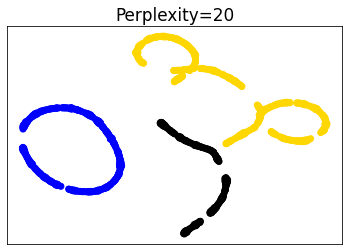

In [4]:
# Best visualization with t-SNE (Analysis made at lesson)
x2D = tSNE(data, y)

### NMI relation with **$\epsilon$** and _MinPoints_
The $\epsilon$ and _MinPoints_ parameters are of fundamental importance for the DBSCAN clustering algorithm: _MinPoints_ is the minimum number of neighbors to consider the sample in question as the "Core-Point" from which the clusters originate, and $\epsilon$ is the radius within which the points must be indented to be categorized as neighbors.
Therefore the _NMI_ (_normalized mutual information_) which calculates the degree of correlation between two clustering algorithms (taking into consideration the number of samples in common between the clustrs of the two algorithms), strongly depends on the epsilone and MinPoints parameters

### How to find **$\varepsilon$** and _MinPoints_
Performing a cross search (Gridsearch, ...) by varying the parameters of epsilon and _MinPoints_ is certainly effective, but it can take a long time to compute. A faster and equally effective technique is to first determine the value of _MinPoints_ and then $\varepsilon$, each with their own strategy:
-  _MinPoints_ : there is no single way to determine it, usually $2 \cdot dim(data)$ <sup>[1]</sup> is used, where $dim(data)$ is the size of the database containing the samples. However, it must be taken into account that for particularly large or very noisy databases, higher _MinPoints_ values are likely to be used.
-  $\varepsilon$ : one of the techniques used to find it is to compute for each point the distance with its _k_-neighbor (where _k_ $\leq$  _MinPoints_ value found previously). Subsequently, the distances are sorted in ascending order and plotted in a graph, called "k-distance graph", that produces a characteristic "elbow plot". The optimal $\varepsilon$ value corresponds to the point of maximum curvature.

<sub> [1]: (Sander et al., 1998) </sub>

In [22]:
# As explained previously we chose as default value MinPoints=2*dim, that in our case is MinPoint=2*3=6
def dbscan_pipeline(x, x2D, MinPoints=6, dist_func='', k=1):
    np.random.seed(100)
    fig, ax = plt.subplots(1,2, figsize=(11,5))
    
    neighbors = NearestNeighbors(n_neighbors=MinPoints)
    neighbors_fit = neighbors.fit(x)
    distances, indices = neighbors_fit.kneighbors(x)
    if dist_func=='avg':
        distances = np.mean(distances, axis=1) #Average distance between neighbours
    else:
        distances = distances[:,k]
    distances = np.sort(distances)

    # calculate and show knee/elbow
    kneedle = kneed.KneeLocator(range(len(distances)), distances, S=1.0, curve='convex', direction='increasing')
    elbow_point = kneedle.elbow
    print('Elbow: ', elbow_point)
    eps = round(distances[elbow_point], 2)
    print('epsilon: ', eps)
    ax[0].plot(range(len(distances)), distances, color='blue')
    ax[0].vlines(elbow_point, 0, max(distances), linestyle='--', color='skyblue')
    ax[0].set_title('eps=%.2f, elbow=%i'%(eps, elbow_point))
    
    dbscan = DBSCAN(eps=eps, min_samples=MinPoints)
    dbscan.fit(x)
    y_hat = dbscan.labels_
    plotting_ax(x2D,y_hat,ax[1])
    nmi=NMI(y_hat, y)
    ax[1].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,MinPoints,nmi))
    plt.show()

Once we have set the _MinPoints_ value ($MinPoints=2\cdot dim$, in our case $dim=3$) we can proceed to compute **$\varepsilon$** with the k-neighbor graphs

----k-neighbor: 1th----
Elbow:  969
epsilon:  39.21


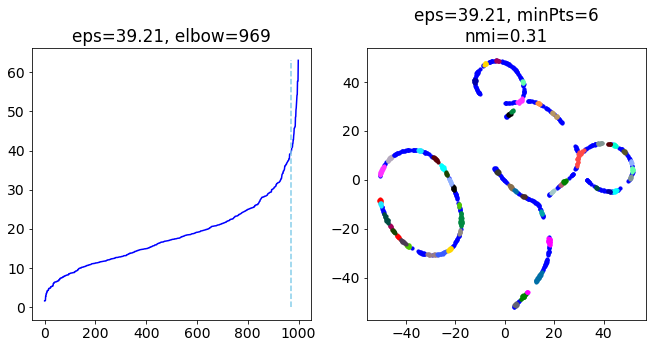

----k-neighbor: 2th----
Elbow:  952
epsilon:  46.61


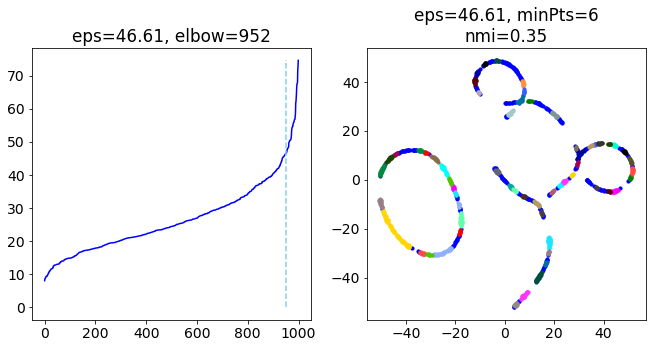

----k-neighbor: 3th----
Elbow:  965
epsilon:  64.23


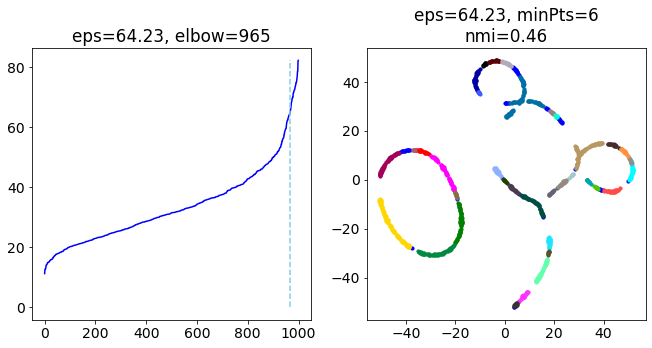

----k-neighbor: 4th----
Elbow:  978
epsilon:  78.8


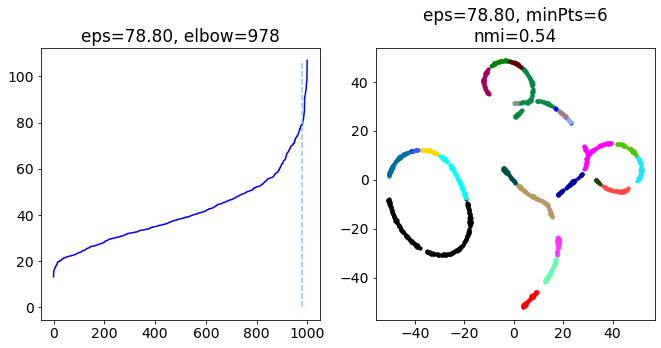

----k-neighbor: 5th----
Elbow:  975
epsilon:  94.29


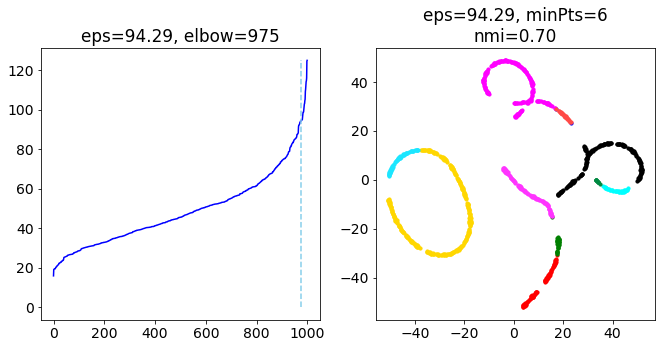

In [23]:
MinPoints = 6
for k in range(1,MinPoints):
    print("----k-neighbor: %ith----"%k)
    dbscan_pipeline(x, x2D, k=k)

Results using the **average** value of k-MinPoints distances

----distance function: 'Average'----
Elbow:  964
epsilon:  50.2


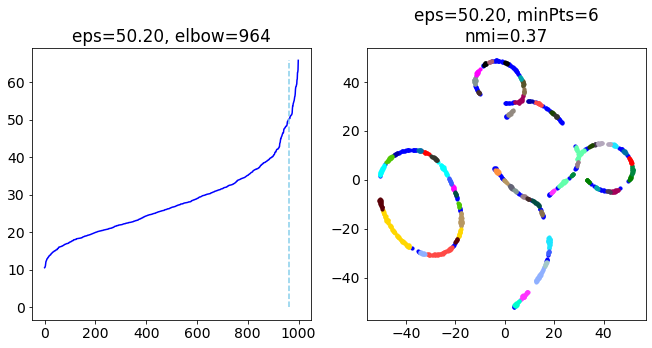

In [24]:
print("----distance function: 'Average'----")
dbscan_pipeline(x, x2D, dist_func='avg')

### observations
From the analysis made in class (using the grid) best _MinPoints_ values are around 3-5 (in agreement with 6 as we set), and best **$\varepsilon=108$** : a bit distant from our best one ($94.29$, $nmi=0.70$). Probably is not used to set a distance range big almost like the maximum distance in the dataset in order to avoid evident noise samples; but in our case we don't have ouliers than, once we set a good _MinPoints_, using a big **$\varepsilon$** allows the more peripheral samples to be attached to existing clusters: this could also explain why by increasing **$\varepsilon$** in the first analysis the nmi gets closer and closer to 1

### extra-analysis: adding outliers
Here we are going to add new samples to verify if the _'elbow-tecnique'_, which doesn't choose huge distances, allows to reach a better _nmi_ value in presence of outliers (some of which are very distant from the original clusters)

C:\Users\Marco\Documents\Anaconda\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([0, 1, 2, 3])

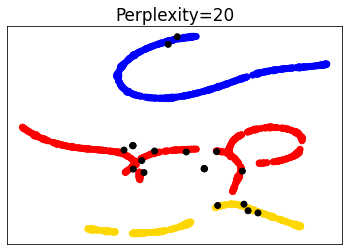

In [25]:
np.random.seed(100)
L_noise = 20
noise_x = np.random.randn(L_noise,D)*250 + np.random.randn(L_noise,D)*100
noise_y = np.array([3]*L_noise)
x_noised = np.concatenate((x, noise_x), axis=0)
y_noised = np.concatenate((y, noise_y))
X = tSNE(x_noised, y_noised, perplexity = 20)
np.unique(y_noised)

----k-neighbor: 1th----
Elbow:  998
epsilon:  57.82


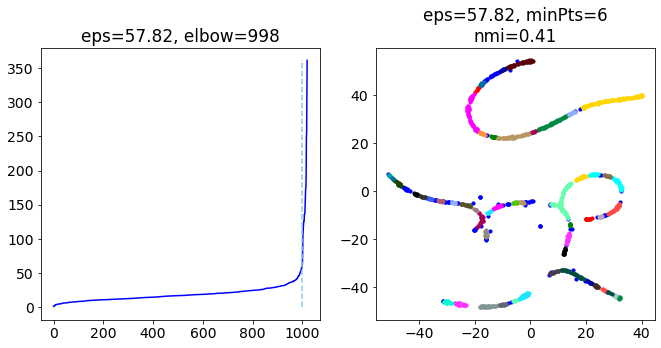

----k-neighbor: 2th----
Elbow:  986
epsilon:  56.87


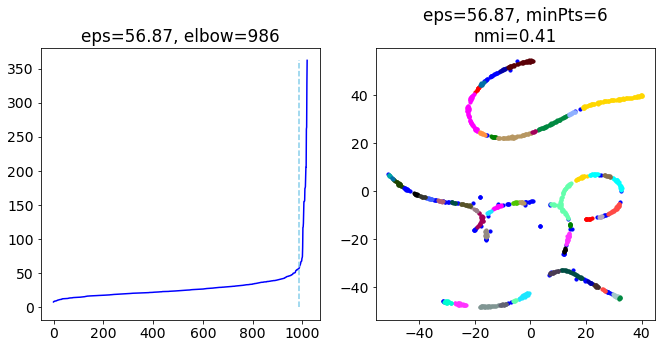

----k-neighbor: 3th----
Elbow:  993
epsilon:  75.13


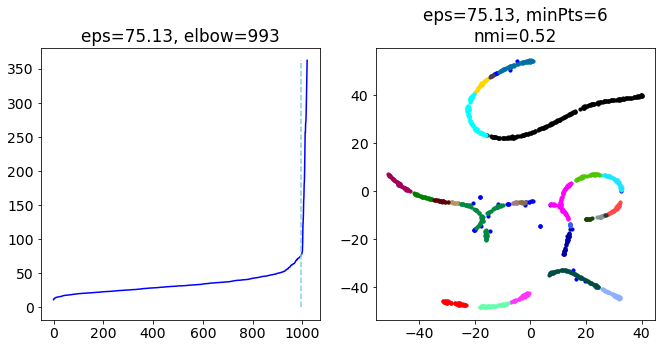

----k-neighbor: 4th----
Elbow:  985
epsilon:  81.15


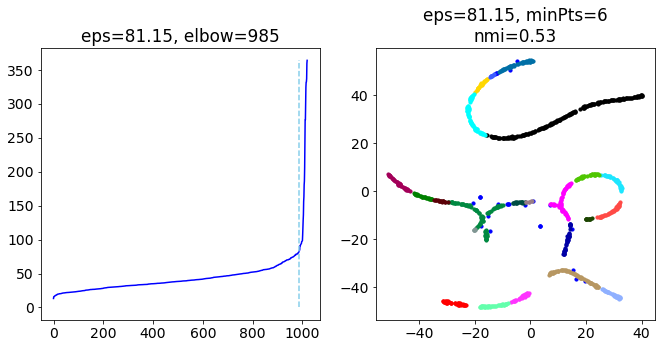

----k-neighbor: 5th----
Elbow:  986
epsilon:  98.95


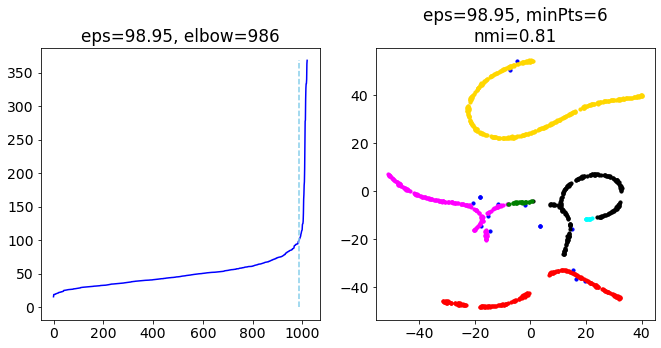

In [26]:
MinPoints = 6
for k in range(1,MinPoints):
    print("----k-neighbor: %ith----"%k)
    dbscan_pipeline(x_noised, X, MinPoints=MinPoints, k=k)

In this case we got a good improvement, increasing the _nmi_ value of $+ 0.11$